In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import lion_optimizer
import time
from sklearn.metrics import precision_score, recall_score, confusion_matrix, accuracy_score
import seaborn as sns
import time

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


# Data preparation

In [27]:
import random
import torch
import numpy as np

# Function to set seed for reproducibility
def set_seed(seed: int):
    random.seed(seed)  # Python's built-in random module
    np.random.seed(seed)  # NumPy's random module
    torch.manual_seed(seed)  # PyTorch's random number generator for CPU
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)  # For single GPU
        torch.cuda.manual_seed_all(seed)  # For multiple GPUs
    # Ensure that cuDNN uses deterministic algorithms
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set your desired seed
set_seed(21)


In [28]:
# Data preparation
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_size = int(0.90 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = torch.utils.data.random_split(trainset, [train_size, val_size])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=256, shuffle=False, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


# Resnet-18 architecture

In [29]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

# Model training

In [30]:
# Define the loss function
criterion = nn.CrossEntropyLoss()

epochs = 20

In [31]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, verbose=False):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model_wts = None
        self.verbose = verbose

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model_wts = model.state_dict()
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.best_model_wts = model.state_dict()
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print("Early stopping triggered")

# Updated training function with early stopping and best weight restoration
def train_model_with_early_stopping(model, optimizer, train_losses, train_accuracies, val_losses, val_accuracies, early_stopping, train_time):
    start_time = time.time()
    for epoch in range(epochs):
        correct = 0
        total = 0
        model.train()
        for i, (inputs, labels) in tqdm(enumerate(trainloader), total=len(trainloader), desc=f"Epoch {epoch+1}/{epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracies.append(100 * correct / total)

        # Validation phase
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_losses.append(val_loss / len(valloader))
        val_accuracies.append(100 * correct / total)

        # Check early stopping condition
        early_stopping(val_loss / len(valloader), model)
        if early_stopping.early_stop:
            #print("Early stopping")
            model.load_state_dict(early_stopping.best_model_wts)
            break
    end_time = time.time()
    training_time = end_time - start_time
    train_time.append(training_time)



In [32]:
# Early stopping parameters
early_stopping = EarlyStopping(patience=3, min_delta=0.01, verbose=True)

# Train adam model with early stopping
print("Training Resnet-18(Adam)")
Resnet18_adam = ResNet18().to(device)
optimizer_adam = optim.Adam(Resnet18_adam.parameters(), lr=0.001)
train_losses_adam = []
train_accuracies_adam = []
val_losses_adam = []
val_accuracies_adam = []
train_time_adam = []
train_model_with_early_stopping(Resnet18_adam, optimizer_adam, train_losses_adam, train_accuracies_adam, val_losses_adam, val_accuracies_adam, early_stopping, train_time_adam)
print("ResNet-18(Adam) training complete with early stopping\n")

# Reset early stopping
early_stopping = EarlyStopping(patience=3, min_delta=0.01, verbose=True)

Lion = lion_optimizer.Lion
# Train Lion model with early stopping
print("Training Resnet-18(Lion)")
Resnet18_lion = ResNet18().to(device)
optimizer_lion = Lion(Resnet18_lion.parameters(), lr=0.001/10)
train_losses_lion = []
train_accuracies_lion = []
val_losses_lion = []
val_accuracies_lion = []
train_time_lion= []
train_model_with_early_stopping(Resnet18_lion, optimizer_lion, train_losses_lion, train_accuracies_lion, val_losses_lion, val_accuracies_lion, early_stopping, train_time_lion)
print("ResNet-18(Lion) training complete with early stopping\n")

Training Resnet-18(Adam)


Epoch 7/20: 100%|██████████| 176/176 [01:01<00:00,  2.87it/s]


Early stopping triggered
ResNet-18(Adam) training complete with early stopping

Training Resnet-18(Lion)


Epoch 6/20: 100%|██████████| 176/176 [00:30<00:00,  5.79it/s]


Early stopping triggered
ResNet-18(Lion) training complete with early stopping



# Evaluation metrics

Test Accuracy for adam Optimizer: 76.99%
Precision for adam Optimizer: 0.80
Recall for adam Optimizer: 0.77
Test Accuracy for Lion Optimizer: 81.21%
Precision for Lion Optimizer: 0.82
Recall for Lion Optimizer: 0.81


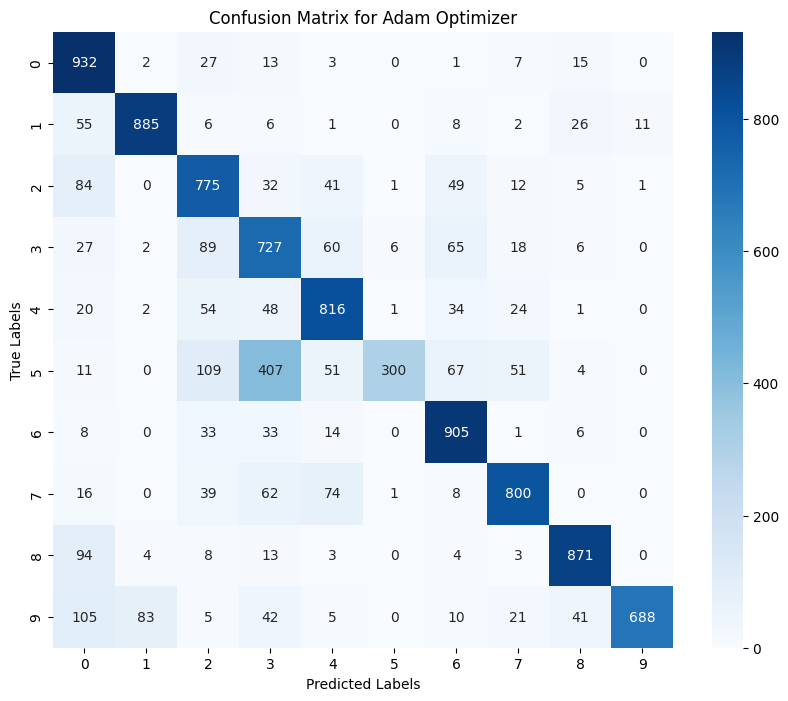

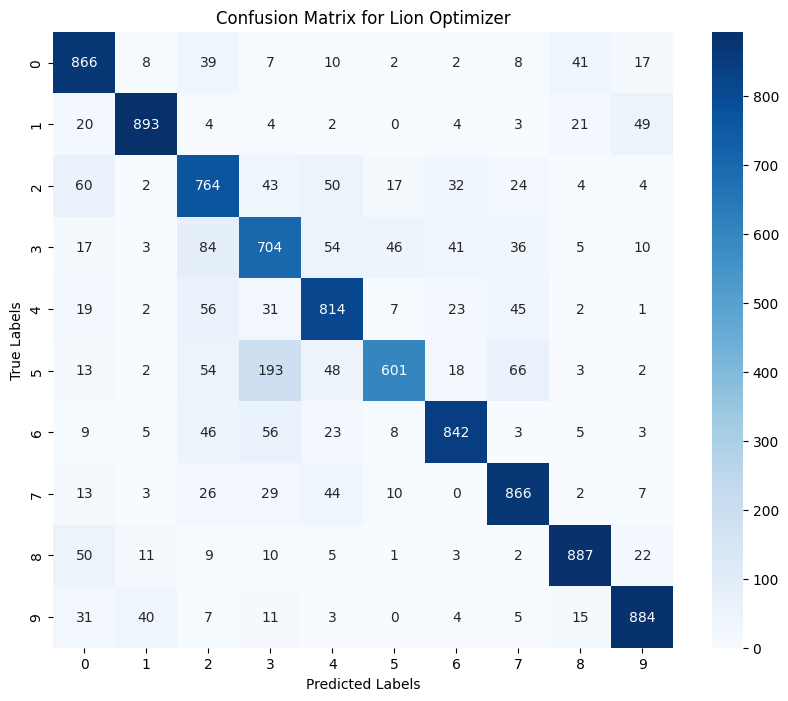

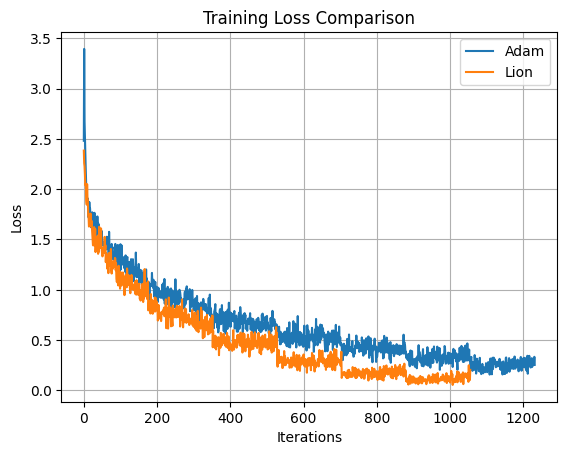

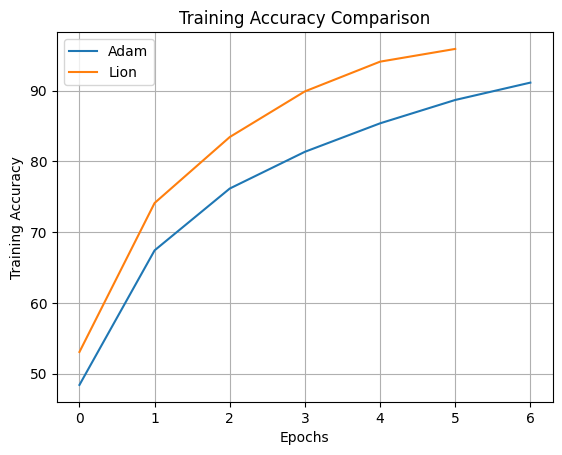

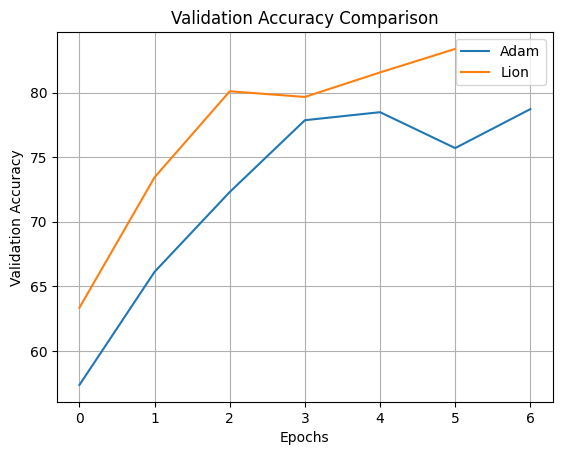

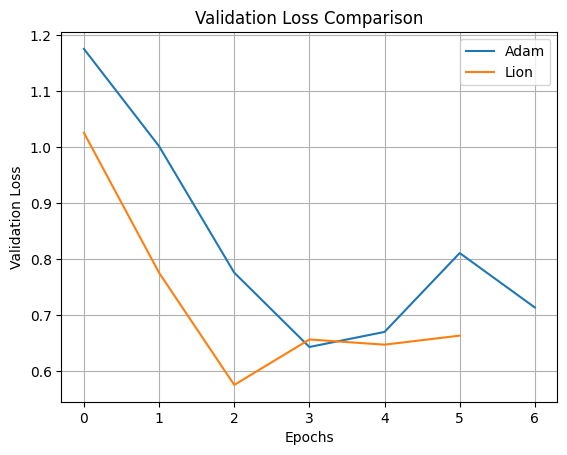

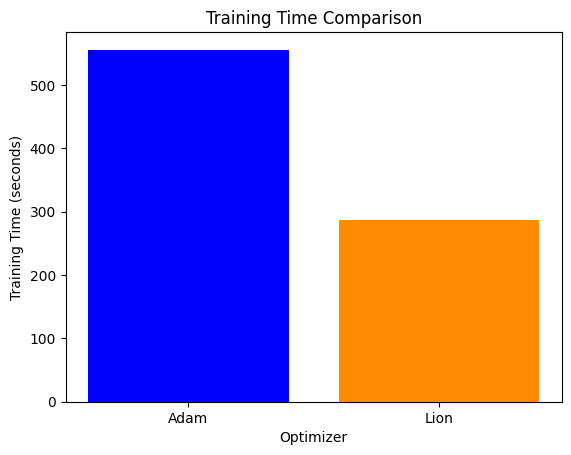

In [33]:
# Test set evaluation
def test_model(model):
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_preds = []
    
    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the appropriate device
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    # Calculate metrics using sklearn
    accuracy = accuracy_score(all_labels, all_preds) * 100
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    
    return accuracy, precision, recall, all_labels, all_preds

test_accuracy_adam, precision_adam, recall_adam, labels_adam, preds_adam = test_model(Resnet18_adam)
test_accuracy_lion, precision_lion, recall_lion, labels_lion, preds_lion = test_model(Resnet18_lion)


print(f'Test Accuracy for adam Optimizer: {test_accuracy_adam:.2f}%')
print(f'Precision for adam Optimizer: {precision_adam:.2f}')
print(f'Recall for adam Optimizer: {recall_adam:.2f}')
print(f'Test Accuracy for Lion Optimizer: {test_accuracy_lion:.2f}%')
print(f'Precision for Lion Optimizer: {precision_lion:.2f}')
print(f'Recall for Lion Optimizer: {recall_lion:.2f}')

# Confusion Matrix
def plot_confusion_matrix(labels, preds, optimizer_name):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix for {optimizer_name} Optimizer')
    plt.show()

plot_confusion_matrix(labels_adam, preds_adam, 'Adam')
plot_confusion_matrix(labels_lion, preds_lion, 'Lion')

# Plot the loss curves for both optimizers
plt.figure()
plt.plot(train_losses_adam, label='Adam')
plt.plot(train_losses_lion, label='Lion')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(train_accuracies_adam, label='Adam')
plt.plot(train_accuracies_lion, label='Lion')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy Comparison')
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(val_accuracies_adam, label='Adam')
plt.plot(val_accuracies_lion, label='Lion')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy Comparison')
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(val_losses_adam, label='Adam')
plt.plot(val_losses_lion, label='Lion')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Comparison')
plt.legend()
plt.grid(True)
plt.show()


training_times = [train_time_adam[0], train_time_lion[0]]
optimizer = ['Adam', 'Lion']
plt.figure()
plt.bar(optimizer, training_times, color=['blue', 'darkorange'])
plt.xlabel('Optimizer')
plt.ylabel('Training Time (seconds)')
plt.title('Training Time Comparison')
plt.show()



In [35]:
import json

# Function to save metrics to a JSON file
def save_metrics_to_json(filename, train_losses, train_accuracies, val_losses, val_accuracies, train_time, test_accuracy, precision, recall):
    data = {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'train_time': train_time,
        'test_accuracy': test_accuracy,
        'test_precision': precision,
        'test_recall': recall
    }
    with open(filename, 'w') as f:
        json.dump(data, f, indent=4)



save_metrics_to_json('adam_metrics_train4.json', train_losses_adam, train_accuracies_adam, val_losses_adam, val_accuracies_adam, train_time_adam, test_accuracy_adam, precision_adam, recall_adam)

save_metrics_to_json('lion_metrics_train4.json', train_losses_lion, train_accuracies_lion, val_losses_lion, val_accuracies_lion, train_time_lion, test_accuracy_lion, precision_lion, recall_lion)

print("Metrics is saved to json")



Metrics is saved to json
